In [26]:
import os
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
%matplotlib widget
%load_ext autoreload
%autoreload 2
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    clean_degree_4,
)
import scipy
from amftrack.pipeline.functions.image_processing.node_id import remove_spurs
from amftrack.pipeline.functions.image_processing.extract_skel import remove_component, remove_holes
import numpy as np
from amftrack.pipeline.development.high_mag_videos.high_mag_videos_fun import *
from scipy import signal
from skimage.morphology import skeletonize
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_new_prince,
    run_back_sub,
    bowler_hat,
)
from scipy.interpolate import griddata
from PIL import Image
import pandas as pd
from scipy.optimize import curve_fit
plt.style.use('presentation.mplstyle')
from scipy.interpolate import interp1d


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
images_path = 'spatial_frequ'
images = os.listdir(images_path)
image = imageio.imread(os.path.join(images_path,images[100]))


C:\Users\coren\AppData\Local\Temp\ipykernel_16464\3440528161.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(images_path,images[100]))


In [37]:
imageio.imsave('etienne.png',image)

In [3]:
image_background = imageio.imread("background.png")
image_background = image_background[:,:image.shape[1]]

C:\Users\coren\AppData\Local\Temp\ipykernel_16464\3002865911.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image_background = imageio.imread("background.png")


In [244]:
image.shape

(22, 288)

In [4]:
binning = 2
magnification = 50
space_pixel_size = 2*1.725/(magnification)*binning #um.pixel

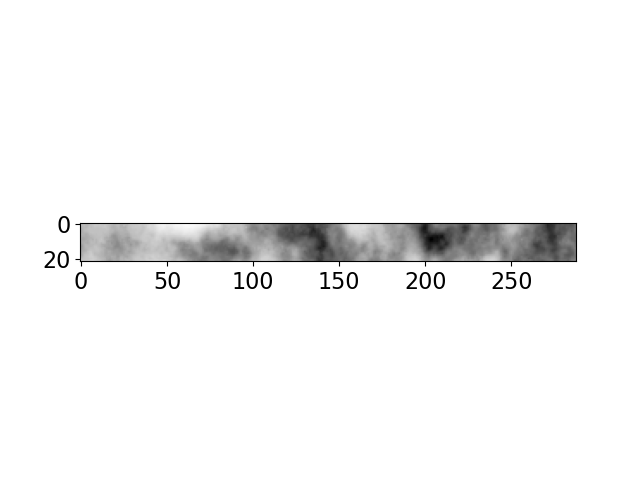

In [123]:
fig,ax = plt.subplots()
ax.imshow(image,cmap = "Greys")

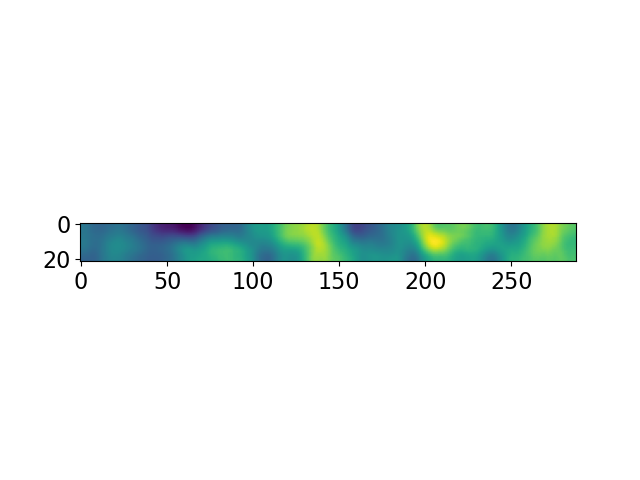

In [95]:
fig,ax = plt.subplots()
ksize = (10,10)
blur = cv2.blur(image,ksize)
ax.imshow(blur)

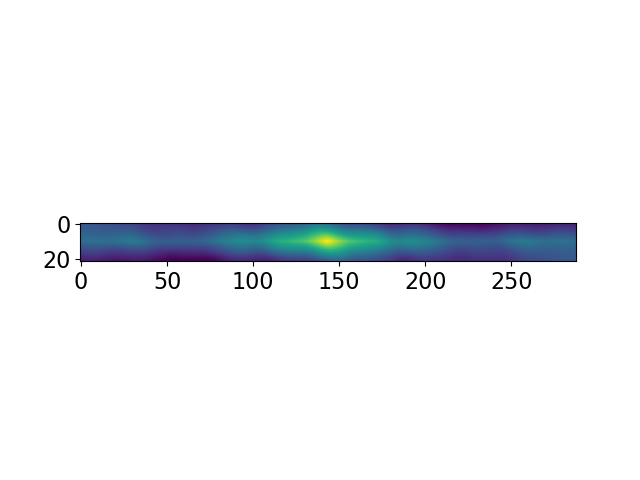

In [77]:
ZMUV_image= (image-np.mean(image))/np.std(image)

autocorrelate = signal.correlate2d(ZMUV_image,ZMUV_image,'same')
fig,ax = plt.subplots()
ax.imshow(np.log(autocorrelate/np.max(autocorrelate)+1))

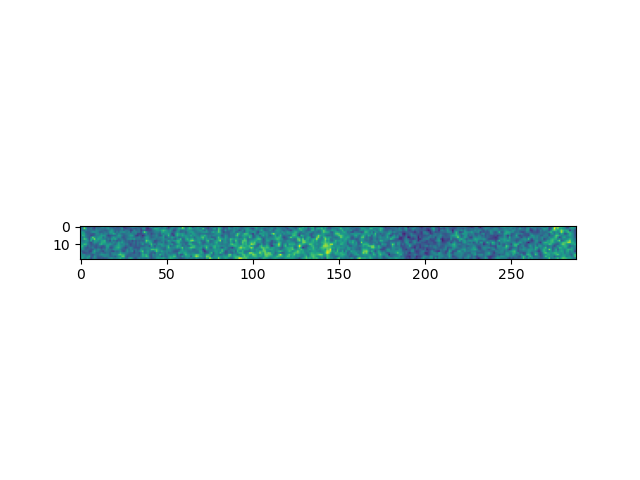

In [6]:
fig,ax = plt.subplots()
ax.imshow(image_background)

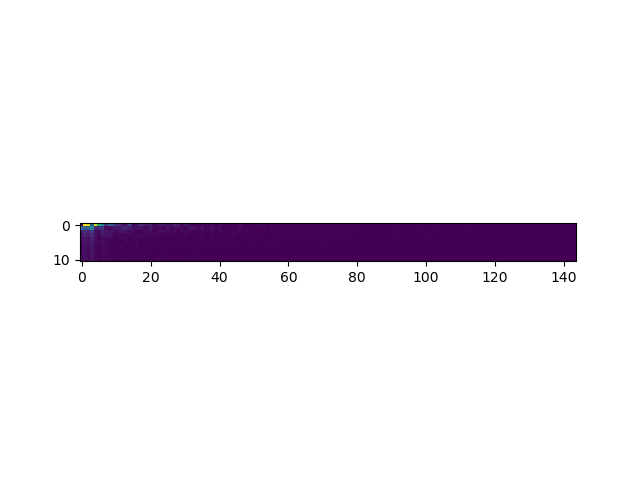

In [7]:
j =10 
ZMUV_image= (image-np.mean(image))/np.std(image)
dark_image_grey_fourier = np.fft.fftshift(np.fft.fft2(ZMUV_image))

fig,ax = plt.subplots()
ax.imshow(abs(dark_image_grey_fourier)[image.shape[0]//2:,image.shape[1]//2:])

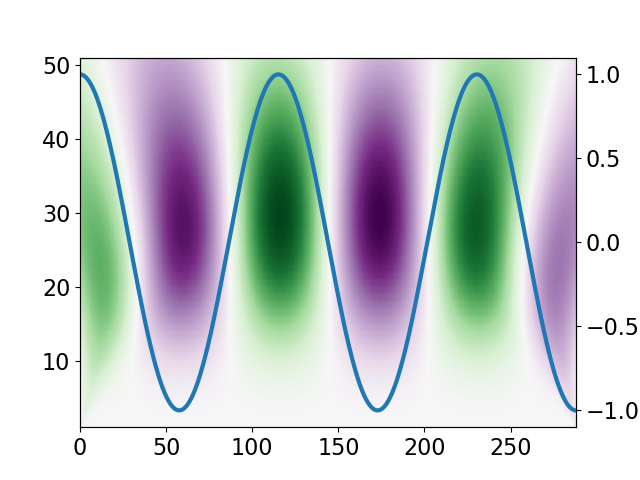

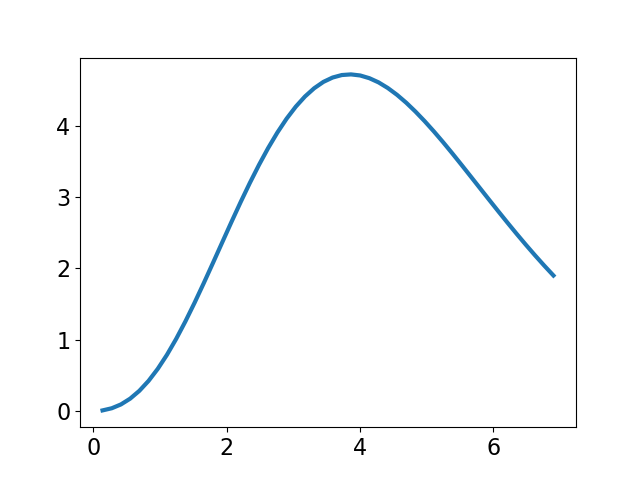

In [96]:
t = np.linspace(0, 2*np.pi, line.shape[0], endpoint=False)
ZMUV_signal  = np.cos(2.5*t)
sig  = ZMUV_signal
widths = np.arange(1, width_max)

cwtmatr = signal.cwt(sig, signal.ricker, widths)
cwtmatr_yflip = np.flipud(cwtmatr)
# fig,ax =plt.subplots()
fig,ax =plt.subplots()
# transform = cwtmatr_yflip/np.array([np.flip(widths) for i in range(cwtmatr_yflip.shape[1])]).transpose()**2
transform = cwtmatr_yflip

# ax.imshow(cwtmatr_yflip, extent=[0, len(sig), 1, 31], cmap='PRGn', aspect='auto',

#            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
ax.imshow(transform, extent=[0, len(sig), 1, width_max], cmap='PRGn', aspect='auto',

           vmax=abs(transform).max(), vmin=-abs(transform).max())
ax2 = ax.twinx()
ax2.plot(sig)
fig,ax =plt.subplots()
frequency_image = np.mean(abs(cwtmatr_yflip),axis=1)

ax.plot(np.flip(widths)*space_pixel_size,np.mean(abs(cwtmatr_yflip),axis=1))


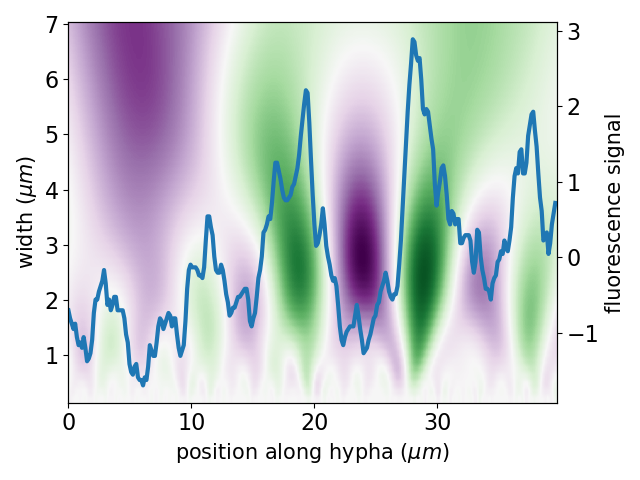

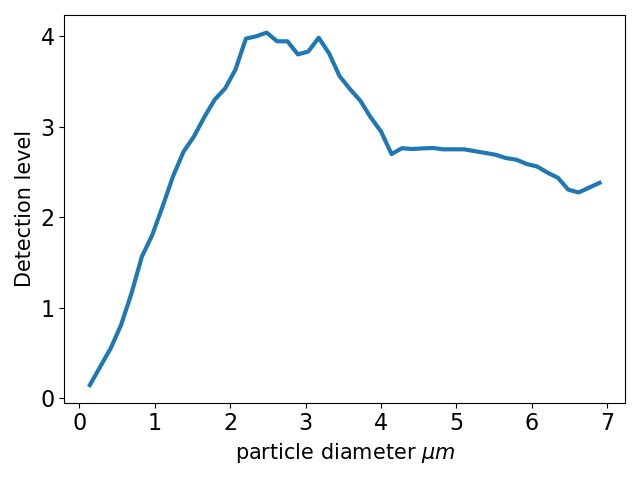

In [128]:
i=10
line =image[i,:]
# ax.plot(line)
width_max = 51

ZMUV_signal = (line-np.mean(line))/np.std(line)
sig  = ZMUV_signal
widths = np.arange(1, width_max)

cwtmatr = signal.cwt(sig, signal.ricker, widths)
cwtmatr_yflip = np.flipud(cwtmatr)
# fig,ax =plt.subplots()
fig,ax =plt.subplots()
# transform = cwtmatr_yflip/np.array([np.flip(widths) for i in range(cwtmatr_yflip.shape[1])]).transpose()**2
transform = cwtmatr_yflip

# ax.imshow(cwtmatr_yflip, extent=[0, len(sig), 1, 31], cmap='PRGn', aspect='auto',

#            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
ax.imshow(transform, extent=[0, len(sig)*space_pixel_size, 1*space_pixel_size, width_max*space_pixel_size], cmap='PRGn', aspect='auto',

           vmax=abs(transform).max(), vmin=-abs(transform).max(),)
ax2 = ax.twinx()
ax2.plot(np.array(range(len(sig)))*space_pixel_size,sig)
ax.set_xlabel('position along hypha ($\mu m$)')
ax.set_ylabel('width ($\mu m$)')
ax2.set_ylabel('fluorescence signal')
plt.tight_layout()
fig,ax =plt.subplots()
frequency_image = np.sum(cwtmatr_yflip*(cwtmatr_yflip>=0)/np.array([np.sum(cwtmatr_yflip>=0,axis=1) for i in range(image.shape[1])]).transpose(),axis=1)

# ax.plot(np.flip(widths)*space_pixel_size/2,np.mean(abs(cwtmatr_yflip),axis=1))
ax.plot(np.flip(widths)*space_pixel_size,np.sum(cwtmatr_yflip*(cwtmatr_yflip>=0)/np.array([np.sum(cwtmatr_yflip>=0,axis=1) for i in range(image.shape[1])]).transpose(),axis=1))

ax.set_xlabel('particle diameter $\mu m$')
ax.set_ylabel('Detection level')
plt.tight_layout()

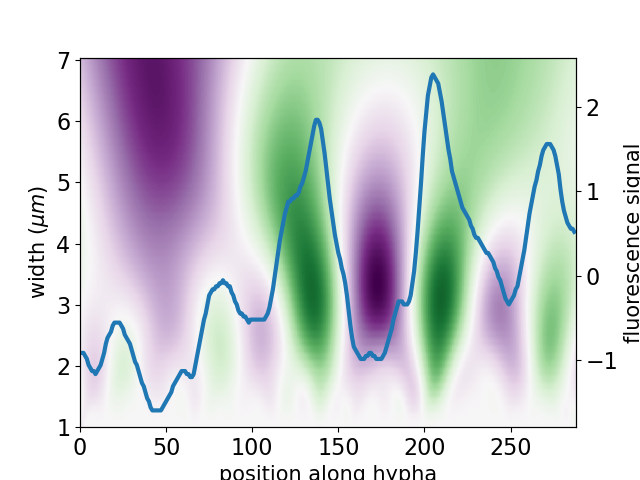

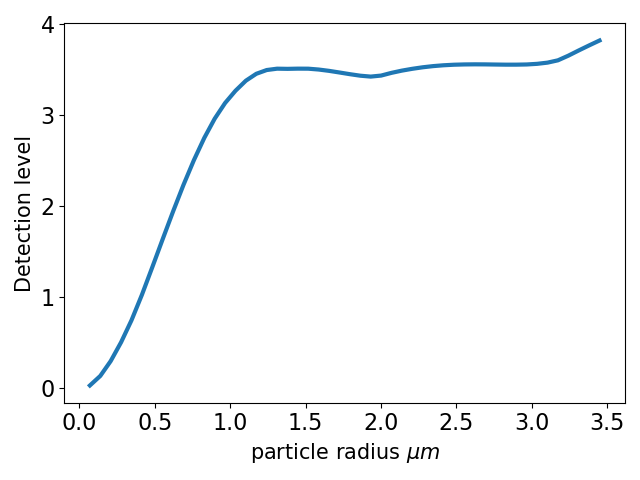

In [98]:
i=10
line =blur[i,:]
# ax.plot(line)
width_max = 51

ZMUV_signal = (line-np.mean(line))/np.std(line)
sig  = ZMUV_signal
widths = np.arange(1, width_max)

cwtmatr = signal.cwt(sig, signal.ricker, widths)
cwtmatr_yflip = np.flipud(cwtmatr)
# fig,ax =plt.subplots()
fig,ax =plt.subplots()
# transform = cwtmatr_yflip/np.array([np.flip(widths) for i in range(cwtmatr_yflip.shape[1])]).transpose()**2
transform = cwtmatr_yflip

# ax.imshow(cwtmatr_yflip, extent=[0, len(sig), 1, 31], cmap='PRGn', aspect='auto',

#            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
ax.imshow(transform, extent=[0, len(sig), 1, width_max*space_pixel_size], cmap='PRGn', aspect='auto',

           vmax=abs(transform).max(), vmin=-abs(transform).max(),)
ax2 = ax.twinx()
ax2.plot(sig)
ax.set_xlabel('position along hypha')
ax.set_ylabel('width ($\mu m$)')
ax2.set_ylabel('fluorescence signal')

fig,ax =plt.subplots()
frequency_image = np.mean(abs(cwtmatr_yflip),axis=1)

ax.plot(np.flip(widths)*space_pixel_size/2,np.mean(abs(cwtmatr_yflip),axis=1))

ax.set_xlabel('particle radius $\mu m$')
ax.set_ylabel('Detection level')
plt.tight_layout()

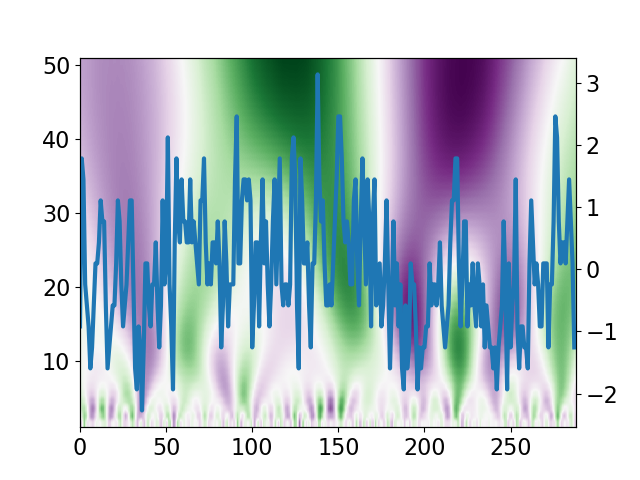

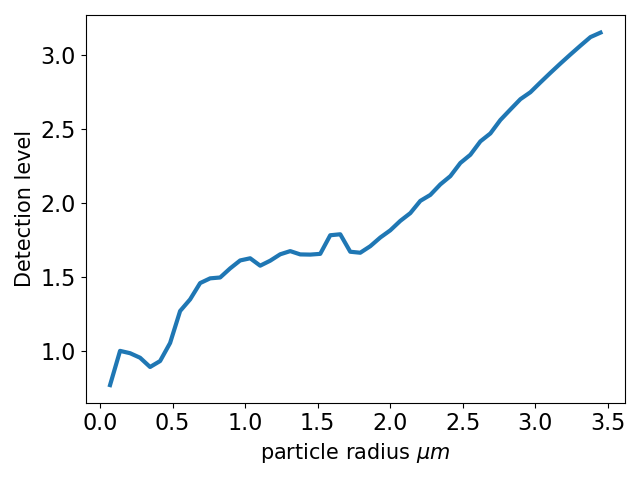

In [105]:
i=5
line =image_background[i,:]
# ax.plot(line)
ZMUV_signal = (line-np.mean(line))/np.std(line)
sig  = ZMUV_signal
widths = np.arange(1, width_max)

cwtmatr = signal.cwt(sig, signal.ricker, widths)
cwtmatr_yflip = np.flipud(cwtmatr)
# fig,ax =plt.subplots()
fig,ax =plt.subplots()
# transform = cwtmatr_yflip/np.array([np.flip(widths) for i in range(cwtmatr_yflip.shape[1])]).transpose()**2
transform = cwtmatr_yflip

# ax.imshow(cwtmatr_yflip, extent=[0, len(sig), 1, 31], cmap='PRGn', aspect='auto',

#            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
ax.imshow(transform, extent=[0, len(sig), 1, width_max], cmap='PRGn', aspect='auto',

           vmax=abs(transform).max(), vmin=-abs(transform).max())
ax2 = ax.twinx()
ax2.plot(sig)
fig,ax =plt.subplots()
frequency_background = np.sum(cwtmatr_yflip*(cwtmatr_yflip>=0)/np.array([np.sum(cwtmatr_yflip>=0,axis=1) for i in range(image.shape[1])]).transpose(),axis=1)
# ax.plot(np.flip(widths)*space_pixel_size/2,np.mean(abs(cwtmatr_yflip),axis=1))
ax.plot(np.flip(widths)*space_pixel_size/2,np.sum(cwtmatr_yflip*(cwtmatr_yflip>=0)/np.array([np.sum(cwtmatr_yflip>=0,axis=1) for i in range(image.shape[1])]).transpose(),axis=1))

ax.set_xlabel('particle radius $\mu m$')
ax.set_ylabel('Detection level')
plt.tight_layout()

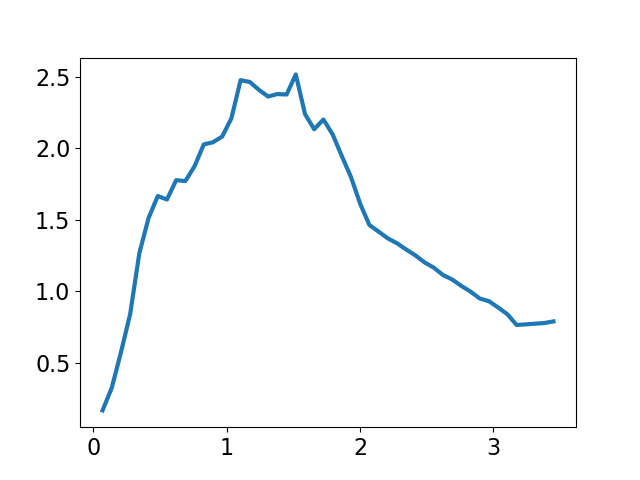

In [106]:
fig,ax =plt.subplots()
ax.plot(np.flip(widths)*space_pixel_size/2,frequency_image/frequency_background)

In [109]:
image_path

'.ipynb_checkpoints'

In [113]:
wavelets = []

for image_path in images[:-1:20]:
    image = imageio.imread(os.path.join(images_path,image_path))    
    for i in range(10,image.shape[0]-10):
        # fig,ax =plt.subplots()
        line =image[i,:]
        # ax.plot(line)
        ZMUV_signal = (line-np.mean(line))/np.std(line)
        sig  = ZMUV_signal
        cwtmatr = signal.cwt(sig, signal.ricker, widths)
        cwtmatr_yflip = np.flipud(cwtmatr)
        # transform = cwtmatr_yflip/np.array([np.flip(widths) for i in range(cwtmatr_yflip.shape[1])]).transpose()
        
        wavelet = np.sum(cwtmatr_yflip*(cwtmatr_yflip>=0)/np.array([np.sum(cwtmatr_yflip>=0,axis=1) for i in range(image.shape[1])]).transpose(),axis=1)
        wavelets.append(wavelet)

C:\Users\coren\AppData\Local\Temp\ipykernel_16464\1685353466.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(images_path,image_path))


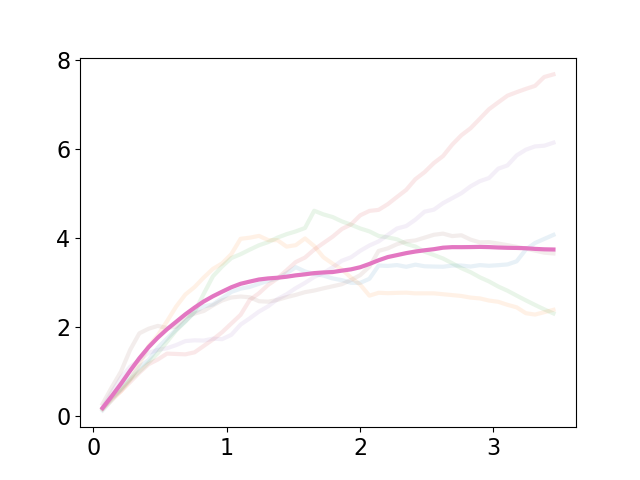

In [116]:
fig,ax =plt.subplots()
for wavelet in wavelets[::10]:
    ax.plot(np.flip(widths)*space_pixel_size/2,wavelet,alpha = 0.1)
ax.plot(np.flip(widths)*space_pixel_size/2,(np.mean(np.array(wavelets),axis=0)))


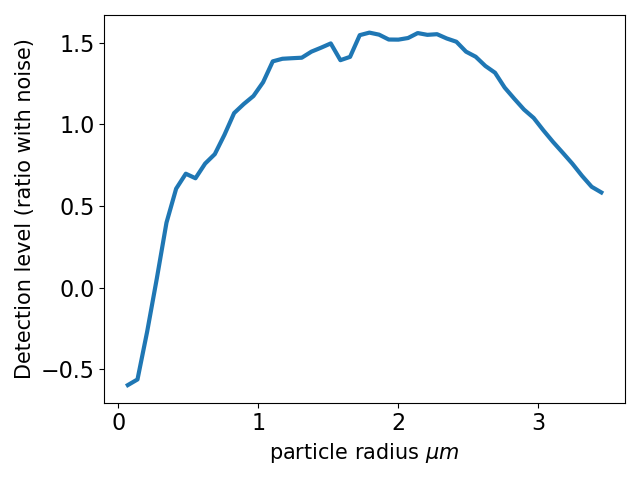

In [118]:
fig,ax =plt.subplots()
# for wavelet in wavelets[::200]:
#     ax.plot(widths*space_pixel_size,wavelet,alpha = 0.1)

ax.plot(np.flip(widths)*space_pixel_size/2,(np.mean(np.array(wavelets),axis=0)-frequency_background))
ax.set_xlabel('particle radius $\mu m$')
ax.set_ylabel('Detection level (ratio with noise)')
plt.tight_layout()

In [61]:
fourrier2d = []

for image_path in images:
    image = imageio.imread(os.path.join(images_path,image_path))    
    ZMUV_image= (image-np.mean(image))/np.std(image)
    dark_image_grey_fourier = np.fft.fftshift(np.fft.fft2(ZMUV_image))
    fourrier2d.append(abs(dark_image_grey_fourier))

C:\Users\coren\AppData\Local\Temp\ipykernel_16464\1545947749.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(images_path,image_path))


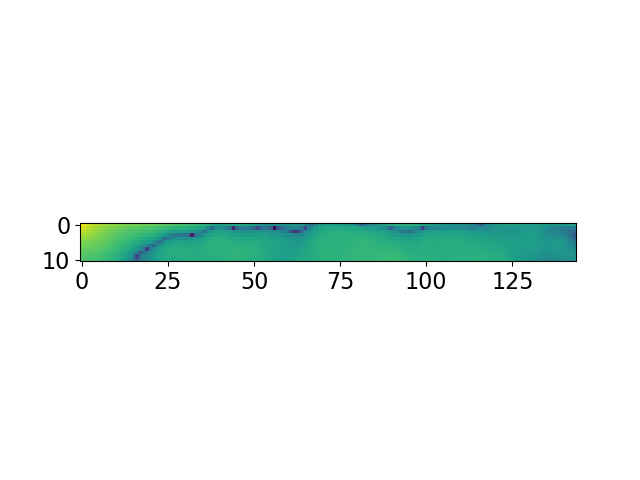

In [68]:
fourrier2d = np.array(fourrier2d)
average_fourrier_2d = np.mean(fourrier2d,axis=0)
autocorrelation = np.fft.ifft2(average_fourrier_2d)
fig,ax = plt.subplots()
ax.imshow(np.log(abs(autocorrelation[:image.shape[0]//2,:image.shape[1]//2])))

In [78]:
autocorrelates = []

for image_path in images[::100]:
    image = imageio.imread(os.path.join(images_path,image_path))    
    ZMUV_image= (image-np.mean(image))/np.std(image)
    autocorrelate = signal.correlate2d(ZMUV_image,ZMUV_image,'same')
    autocorrelates.append(autocorrelate)



C:\Users\coren\AppData\Local\Temp\ipykernel_16464\1118446165.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(images_path,image_path))


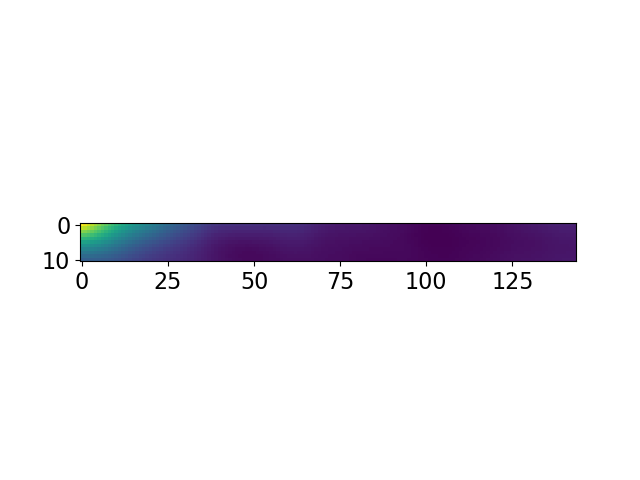

In [81]:
fig,ax = plt.subplots()
to_plot = np.mean(autocorrelates,axis=0)
to_plot = to_plot/np.max(to_plot)
# to_plot = np.log(to_plot+1)
ax.imshow(to_plot[image.shape[0]//2:,image.shape[1]//2:])

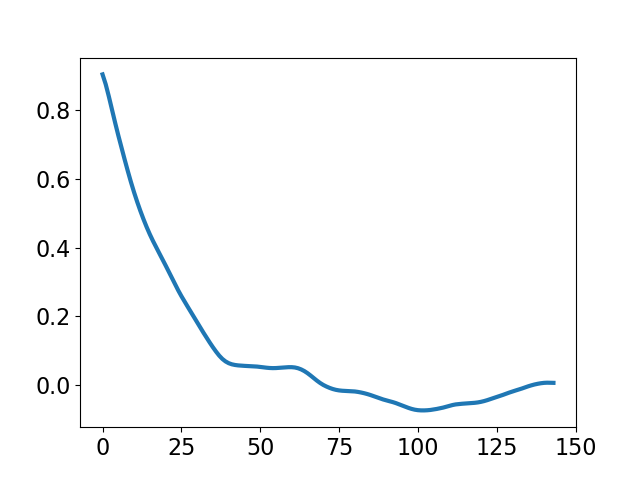

In [86]:
fig,ax = plt.subplots()
ax.plot(to_plot[image.shape[0]//2,image.shape[1]//2:])

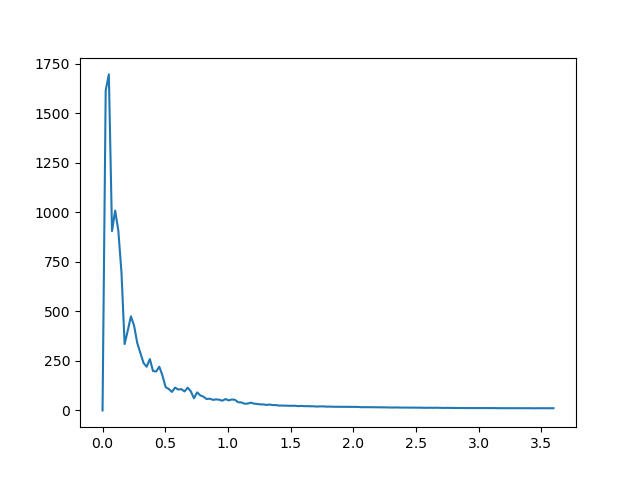

In [198]:
fig,ax = plt.subplots()
freqs  = np.fft.fftfreq(image.shape[1],space_pixel_size)

ax.plot(freqs[:image.shape[1]//2],np.mean(fourrier2d,axis=0)[image.shape[0]//2,image.shape[1]//2:])

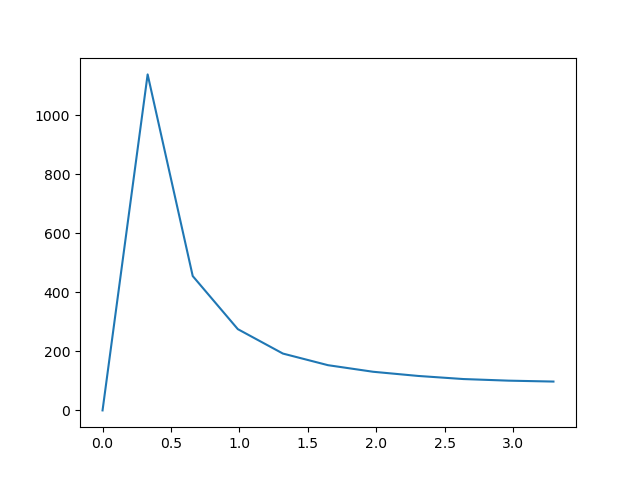

In [199]:
fig,ax = plt.subplots()
freqs  = np.fft.fftfreq(image.shape[0],space_pixel_size)

ax.plot(freqs[:image.shape[0]//2],np.mean(fourrier2d,axis=0)[image.shape[0]//2:,image.shape[1]//2])

In [38]:
fourriers = []

for image_path in images:
    image = imageio.imread(os.path.join(images_path,image_path))    
    for i in range(5,image.shape[0]-5):
        # fig,ax =plt.subplots()
        line =image[i,:]
        # ax.plot(line)
        ZMUV_signal = (line-np.mean(line))/np.std(line)
        fourrier = np.fft.fft(ZMUV_signal)

        fourriers.append(fourrier)


C:\Users\coren\AppData\Local\Temp\ipykernel_16464\107480493.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(images_path,image_path))


In [ ]:
fig,ax =plt.subplots()
freqs  = np.fft.fftfreq(image.shape[1],space_pixel_size)
# for fourrier in fourriers[::200]:
#     ax.plot(freqs,abs(fourrier),alpha = 0.1)

ax.plot(freqs,np.mean(abs(np.array(fourriers)),axis=0))
ax.set_yscale('log')
ax.set_ylim(1,100)
ax.set_xlim(0,3)

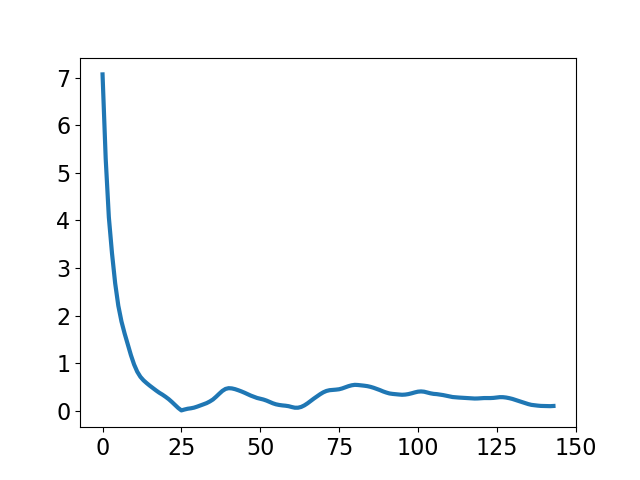

In [66]:
fig,ax =plt.subplots()
ax.plot(np.array(range(image.shape[1]//2)),abs(inverse_transform)[:image.shape[1]//2])

In [83]:
50*space_pixel_size

6.9

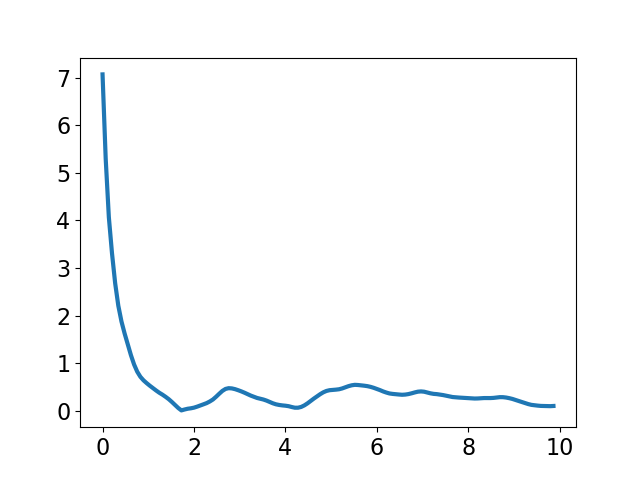

In [60]:
inverse_transform = np.fft.ifft(np.mean(abs(np.array(fourriers)),axis=0))
x  = np.fft.fftfreq(image.shape[1])

fig,ax =plt.subplots()
ax.plot(np.array(range(image.shape[1]//2))*space_pixel_size/2,abs(inverse_transform)[:image.shape[1]//2])

(0.0, 3.0)

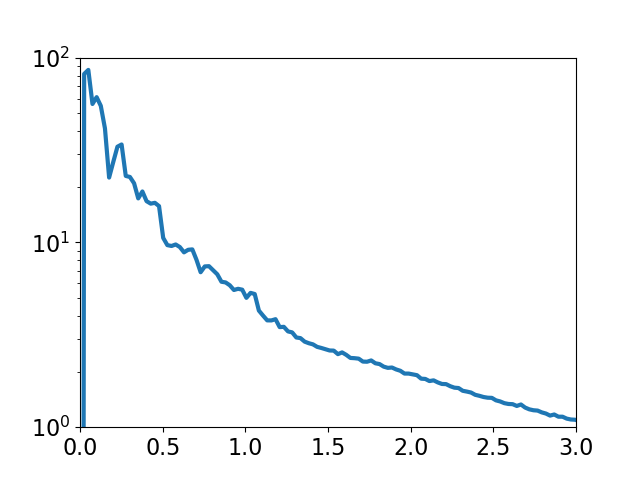

In [41]:
fig,ax =plt.subplots()
freqs  = np.fft.fftfreq(image.shape[1],space_pixel_size)
# for fourrier in fourriers[::200]:
#     ax.plot(freqs,abs(fourrier),alpha = 0.1)

ax.plot(freqs,np.mean(abs(np.array(fourriers)),axis=0))
ax.set_yscale('log')
ax.set_ylim(1,100)
ax.set_xlim(0,3)

(0.0, 3.0)

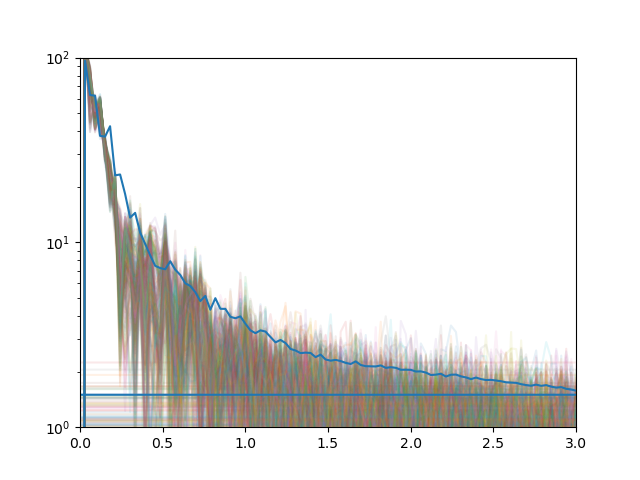

In [47]:
fig,ax =plt.subplots()
freqs  = np.fft.fftfreq(image.shape[1],space_pixel_size)
for fourrier in fourriers[:200]:
    ax.plot(freqs,abs(fourrier),alpha = 0.1)

ax.plot(freqs,np.mean(abs(np.array(fourriers)),axis=0))
ax.set_yscale('log')
ax.set_ylim(1,100)
ax.set_xlim(0,3)

In [ ]:
fourriers = []

for image_path in images:
    image = imageio.imread(os.path.join(images_path,image_path))    
    for i in range(5,image.shape[0]-5):
        # fig,ax =plt.subplots()
        line =image[i,:]
        # ax.plot(line)
        ZMUV_signal = (line-np.mean(line))/np.std(line)
        fourrier = np.fft.fft(ZMUV_signal)

        fourriers.append(fourrier)
